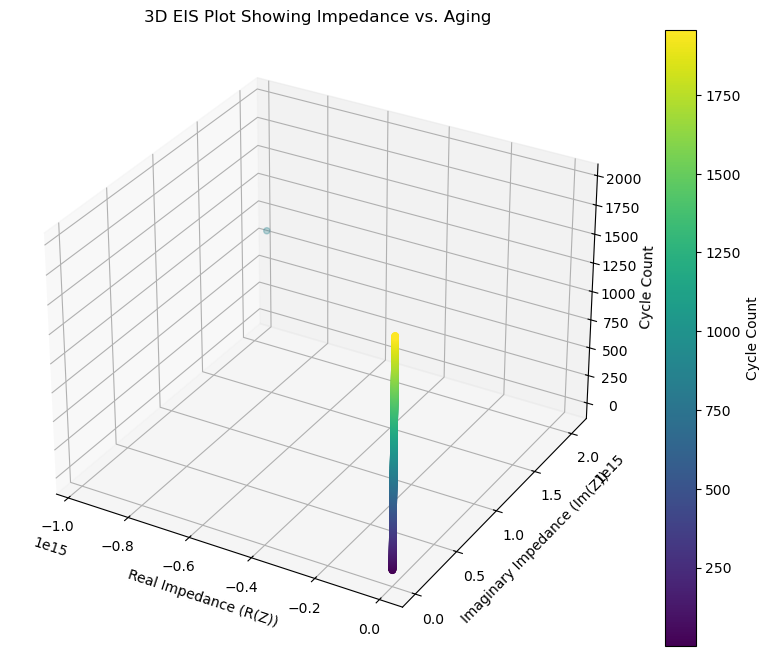

In [7]:
#a)
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

metadata_path = r"D:\metadata.csv"
data = pd.read_csv(metadata_path)

impedance_data = data[data['type'] == 'impedance'].copy()

if 'Re' not in impedance_data.columns or 'Rct' not in impedance_data.columns:
    raise ValueError("Dataset must contain 'Re' and 'Rct' for impedance data.")

impedance_data['Re'] = pd.to_numeric(impedance_data['Re'], errors='coerce').fillna(0.0)
impedance_data['Rct'] = pd.to_numeric(impedance_data['Rct'], errors='coerce').fillna(0.0)

if 'Cycle' not in impedance_data.columns:
    impedance_data['Cycle'] = range(1, len(impedance_data) + 1)

real_impedance = impedance_data['Re']
imag_impedance = impedance_data['Rct']
cycle_count = impedance_data['Cycle']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(real_impedance, imag_impedance, cycle_count, 
                     c=cycle_count, cmap='viridis', marker='o')

ax.set_xlabel('Real Impedance (R(Z))')
ax.set_ylabel('Imaginary Impedance (Im(Z))')
ax.set_zlabel('Cycle Count')
ax.set_title('3D EIS Plot Showing Impedance vs. Aging')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cycle Count')

plt.show()


   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.742571          0.001106             11.838381         -0.0006   
1          3.925105          1.491764             11.780438          1.4995   
2          3.940043          1.491915             11.652214          1.4995   
3          3.949894          1.491505             11.570002          1.4995   
4          3.957889          1.492496             11.472317          1.4995   

   Voltage_charge    Time  
0           0.002   0.000  
1           4.808   2.579  
2           4.821   8.610  
3           4.834  14.547  
4           4.834  20.500  


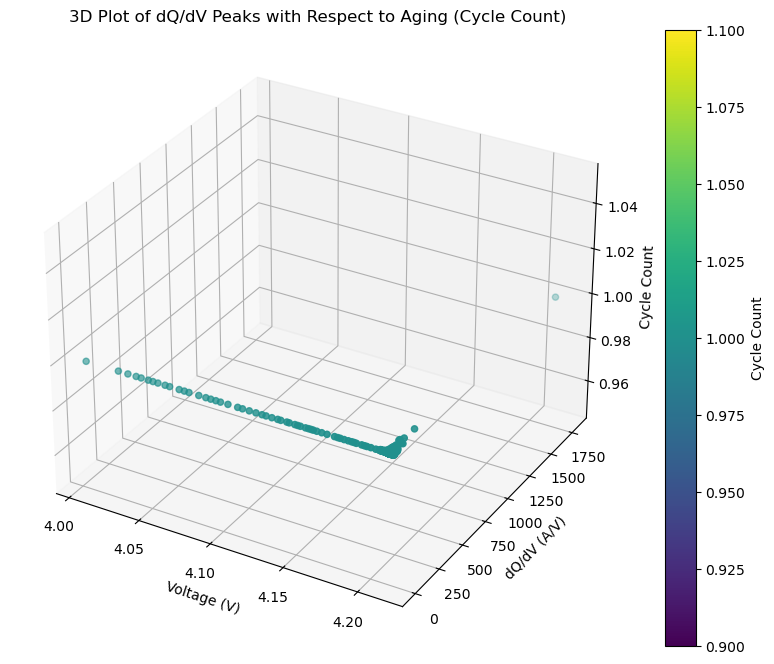

In [11]:
#b)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d import Axes3D

file_path = r"D:\dataset2.csv" 
data = pd.read_csv(file_path)

print(data.head())

if 'Voltage_measured' not in data.columns or 'Current_measured' not in data.columns or 'Time' not in data.columns:
    raise ValueError("Dataset must contain 'Voltage_measured', 'Current_measured', and 'Time' columns.")


data['Capacity'] = np.cumsum(data['Current_measured'] * np.diff(data['Time'], prepend=0) / 3600)  

data['Cycle'] = data.groupby('Voltage_measured').cumcount() + 1  

cycle_counts = []
voltage_values = []
dQ_dV_values = []

for cycle_number in data['Cycle'].unique():
    cycle_data = data[data['Cycle'] == cycle_number]
    
    voltage = cycle_data['Voltage_measured'].values
    capacity = cycle_data['Capacity'].values

    dV = np.diff(voltage)
    dQ = np.diff(capacity)
    dQ_dV = dQ / dV  

    peaks, _ = find_peaks(dQ_dV, height=0)  
    
    for peak in peaks:
        cycle_counts.append(cycle_number)  
        voltage_values.append(voltage[peak])  
        dQ_dV_values.append(dQ_dV[peak])  

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(voltage_values, dQ_dV_values, cycle_counts, c=cycle_counts, cmap='viridis', marker='o')

ax.set_xlabel('Voltage (V)')
ax.set_ylabel('dQ/dV (A/V)')
ax.set_zlabel('Cycle Count')
ax.set_title('3D Plot of dQ/dV Peaks with Respect to Aging (Cycle Count)')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cycle Count')

plt.show()


        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5  00005.csv   

             Capacity                   Re                  Rct  
0  1.6743047446975208                  NaN                  NaN  
1                 NaN  0.05605783343888099  0.20097016584458333  
2                 NaN     

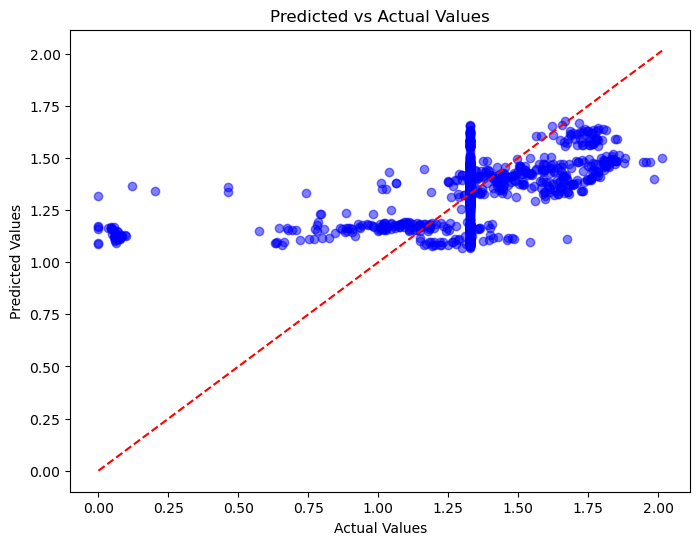

In [3]:
#c)
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


file_path = r'D:/metadata.csv'
df = pd.read_csv(file_path)

print(df.head())

X = df.drop(columns=['Capacity'])  
y = df['Capacity'] 

non_numeric_columns = X.select_dtypes(include=['object']).columns
print(f"Non-numeric columns: {non_numeric_columns}")

label_encoder = LabelEncoder()
for col in non_numeric_columns:
    X[col] = label_encoder.fit_transform(X[col].astype(str))

imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)

y = pd.to_numeric(y, errors='coerce')  

imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).ravel()

print("Any NaN values in X after imputation?", pd.isnull(X_imputed).any())
print("Any NaN values in y after imputation?", pd.isnull(y_imputed).any())

df_clean = pd.DataFrame(X_imputed, columns=X.columns)
df_clean['Capacity'] = y_imputed

df_clean = df_clean.dropna()

X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(columns=['Capacity']), df_clean['Capacity'], test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Predictions:", y_pred)
print("True Values:", y_test.values)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
